Image batch shape: torch.Size([4, 3, 32, 32])
Labels: tensor([8, 9, 8, 3])


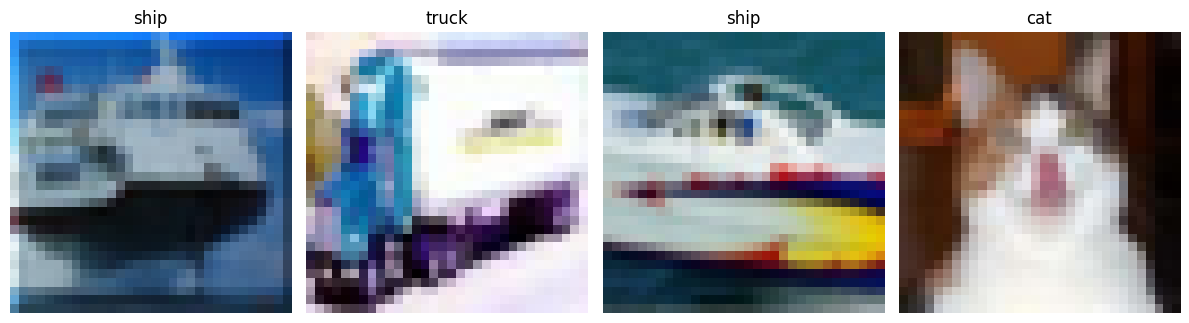

In [2]:
import os
import ssl

os.environ['CURL_CA_BUNDLE'] = ''
os.environ['REQUESTS_CA_BUNDLE'] = ''

ssl._create_default_https_context = ssl._create_unverified_context

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(), #converting images to PyTorch format
])

print("Downloading CIFAR-10 dataset...")
train_dataset = datasets.CIFAR10(
    root='../data', #where to save it
    train=True, #get training data
    download=False, #download if not already there
    transform=transform #apply image processing
)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True) #4 images given at random

dataiter = iter(train_loader)
images, labels = next(dataiter) #next 4 batches given, 

print(f"Image batch shape: {images.shape}") #image
print(f"Labels: {labels}")

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' ] #creates a lookup table

fig, axes = plt.subplots(1, 4, figsize=(12, 13)) #create 1 row, 4 columns of plots
for i in range(4):
    img = images[i].permute(1, 2, 0).numpy() #rearrange data format for display - pyTorch use [Channels, Height, Width]
    axes[i].imshow(img) #display image 
    axes[i].set_title(f"{classes[labels[i]]}") #add label above
    axes[i].axis('off') #hide axis numbers
plt.tight_layout()
plt.show()



In [3]:
class SimpleAttention(nn.Module):
    """
    Simple self-attention mechanism to understand the basics.
    This is what Vision Transformers use to let image patches "look at" each other.
    """

    def __init__(self, dim, num_heads=4):
        super().__init__()
        self.num_heads = num_heads #number of attention experts
        self.dim = dim #feature vectors of each patch
        self.head_dim = dim // num_heads

        self.qkv = nn.Linear(dim, dim * 3) #linear layer (performs affine transformation), creates QKV
        self.proj = nn.Linear(dim, dim) #refines the result

    def forward(self, x):
        B, N, C = x.shape
        #the below(permuation) is to prepare the input for attention computation
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = ( q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5) #dot product (comparison between patches)
        attn = attn.softmax(dim=-1) #turns the comparisons into probabilites

        x = (attn @ v).transpose(1, 2).reshape(B, N, C) #first you find the weighted sum(attn * v) and then make the patch the focus(heads within patches), then reshape to combine 4 heads back to 64 dim
        x = self.proj(x) #refinement 

        return x, attn

print("Testing attention mechanism...")
attention_layer = SimpleAttention(dim=64, num_heads=4)

dummy_input = torch.randn(1, 16, 64)
output, attn_weights = attention_layer(dummy_input) #output is what the neural network learned and what goes to the next layer, attn_weights is how the patches attened to other patches so basically how it learned and what it focused on 

print(f"✔️ Input shape: {dummy_input.shape}")
print(f"✔️ Output shape: {output.shape}")
print(f"✔️ Attention weights shape: {attn_weights.shape}")
print("\nAttention mechanism working!")
    
        
        

Testing attention mechanism...
✔️ Input shape: torch.Size([1, 16, 64])
✔️ Output shape: torch.Size([1, 16, 64])
✔️ Attention weights shape: torch.Size([1, 4, 16, 16])

Attention mechanism working!


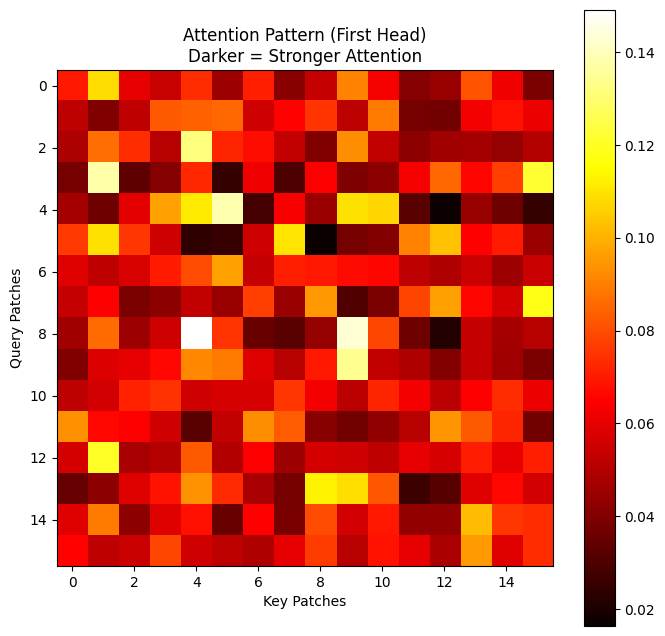


How to read this:
- Each row represents one image patch
- Each column shows which patches it's attending to
- Darker colors = stronger attention connection


In [4]:
fig, ax = plt.subplots(figsize=(8, 8))

attn_to_plot = attn_weights[0, 0].detach().numpy()

im = ax.imshow(attn_to_plot, cmap='hot', interpolation='nearest')
ax.set_title('Attention Pattern (First Head)\nDarker = Stronger Attention')
ax.set_xlabel('Key Patches')
ax.set_ylabel('Query Patches')
plt.colorbar(im, ax=ax)
plt.show()

print("\nHow to read this:")
print("- Each row represents one image patch")
print("- Each column shows which patches it's attending to")
print("- Darker colors = stronger attention connection")


## What I Learned About Attention

### What is attention?
Attention is how much a neural network model focuses on a particular subject compared to others.

### Why is this useful for tracking objects?
It helps the model identify and focus on the most important object in their view. 

### What's computationally expensive?
The dot product operation is expensive - q @ k.transpose. 

### Questions I still have:
- Does attention operations only occure during training or happens once the model is deployed
- Should I be able to describe the operations of qkv from heart?
- Is there a difference between attention and self-attention?
- 

## Potential Datasets for Projectile Tracking

### Option 1: MOT Challenge (Multiple Object Tracking)
**URL:** https://motchallenge.net/

**What I found:**
- The website contains mostly videos of pedestrians walking around on different types of streets day/night

**Good for our project?** 
 - I don't think it's good for this project, since we're more focused on projecticles evasion and the videos of pedestrians walking doesn't provide that training.

---

### Option 2: Synthetic Data (Generate Our Own)
**Approach:** Create simple moving dots/circles with Python

**Pros:**
- Full control over speed, trajectory
- Can make it exactly like projectiles

**Cons:**
- Not realistic
- Might not work on real video

**Good for our project?** 
- I think a setup similar to this would be more ideal than using videos for MOT Challenge since we can simulate the environment we want exactly. I also don't believe we'll find videos for porjectile training as easily as we can walk for street videos. The Figure AI humanoid was also trained in a simulation environment 80% of the way which allowed for fast iteration.

---

### Decision: Which should we use first?

- I think using a simulation environment/synthetic data is the best approach. I'll be able to use the exact data I want and with the new improvements in simulation environments I can train the model 80% of the way and use real-life video/experience for the last 20%.